# Table of contents

- [Import libraries](#import_libraries)
- [Load processed dataset](#load_dataset)
- [Split data into features and labels](#split_data)
- [Baseline algorithms](#baseline_algorithms)
- [Grid search and hyper-parameter tuning](#grid_search)
    - [Logistic regression](#grid_logistic1)
    - [XGBoost classifier](#grid_xgboost1)
- [Synthetic Minority Oversampling (SMOTE)]
- [Feature selection using Recursive Feature Elimination](#rfe)
    - [Baseline algorithms]
    - [Grid search and hyper-parameter tuning]
    - [Synthetic Minority Oversampling (SMOTE)]

# Import libraries <a name="import_libraries"></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load processed dataset <a name="load_dataset"></a>

In [2]:
path = '../data/'
train = pd.read_csv(path+'processed-train.csv',delimiter=',')
test = pd.read_csv(path+'processed-test.csv',delimiter=',')
train.head()

,age,month,day_of_week,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,-1.146223,7,5,0.387151,0.845340,0.599402,-0.490205,0.772003,0.865709,-1,...,0,0,0,0,0,1,1,1,1,0
1,1.076166,6,3,2.147042,0.845340,1.602685,-0.275213,0.716988,0.865709,-1,...,0,0,0,1,0,0,0,1,1,0
2,-1.146223,8,2,0.973782,0.845340,-0.269988,1.086402,0.774320,0.865709,-1,...,0,0,0,1,0,0,0,0,1,0
3,-0.511255,5,4,-0.786110,0.650722,0.738797,1.014738,0.714672,0.326483,-1,...,0,0,0,1,0,0,0,1,1,0
4,0.017885,5,2,-0.786110,-1.230581,-1.280608,-1.326284,-1.352159,-1.009227,-1,...,1,0,0,0,0,0,0,0,1,0


# Split data into features and labels <a name="split_data"></a>

In [3]:
# Predictors
x_train = train.drop(['y'], 1)
x_test = test.drop(['y'], 1)

# Target values
y_train = train['y']
y_test = test['y']

# Baseline algorithms <a name="baseline_algorithms"></a>

Let us run some baseline algorithms with default hyper-parameters on the training data to see how they perform. We will consider the following algorithms: **Logistic regression**, **Decision tree**, **Random forest**, **Gradient boosting classifier** and **k-Nearest neighbor**. For each algorithm, we will perform 5-fold cross-validation on the training set and store the mean classification accuracy and mean AUC-ROC (Area under ROC curve) along with the standard deviations.

In [6]:
# Make a list of algorithms to implement
models = []
models.append(('Logistic regression', LogisticRegression(max_iter=500)))
models.append(('k-Nearest neighbor', KNeighborsClassifier()))
models.append(('Decision tree', DecisionTreeClassifier()))
models.append(('Random forest', RandomForestClassifier()))
models.append(('XGBoost classifier', XGBClassifier()))

In [7]:
# Make a dataframe to store classification metrics
col = ['Algorithm', 'Mean ROC-AUC', 'S.D. AUC-ROC', 'Mean Accuracy', 'S.D. Accuracy']
df_results = pd.DataFrame(columns=col)
auc_results = []
acc_results = []
i = 0

# Fit the models one by one
for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)  # 5-fold cross-validation
    cv_auc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    auc_results.append(cv_auc_results)
    cv_acc_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')
    acc_results.append(cv_acc_results)
    df_results.loc[i] = [name,
                         cv_auc_results.mean(),
                         cv_auc_results.std(),
                         cv_acc_results.mean(),
                         cv_acc_results.std()
                         ]
    i += 1
    print(i)
df_results.sort_values(by=['Mean ROC-AUC'], ascending=False)

1
2
3
4
5
6


,Algorithm,Mean ROC-AUC,S.D. AUC-ROC,Mean Accuracy,S.D. Accuracy
4,Gradient boosting classifier,0.799690,0.006566,0.901548,0.003802
0,Logistic regression,0.780577,0.009218,0.901214,0.003305
5,XGBoost classifier,0.776692,0.011932,0.895446,0.004962
3,Random forest,0.773770,0.004436,0.892623,0.003945
1,k-Nearest neighbor,0.723551,0.009259,0.889951,0.002840
2,Decision tree,0.624478,0.010074,0.840255,0.002616


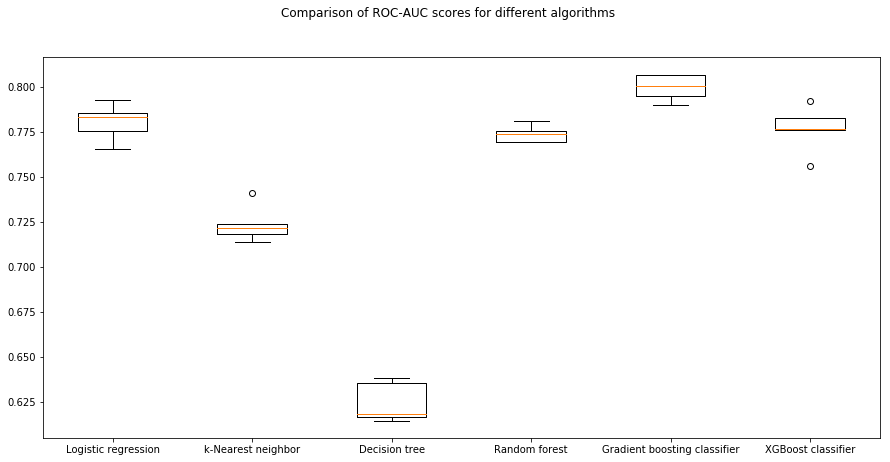

In [8]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Comparison of ROC-AUC scores for different algorithms')
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(df_results['Algorithm'])
plt.show()

So although the classification accuracies for all the models except decision tree are more or less similar, it is not the right indicator because of the class imbalance. Going by the ROC-AUC score, which quantifies a classifier's ability to differentiate between the classes, gradient boosting classifier and logistic regression are better baseline models.

# Grid search and hyper-parameter tuning <a name="grid_search"></a>

### Logistic regression <a name="grid_logistic1"></a>

In [9]:
logistic = LogisticRegression(max_iter=1000)
C = np.logspace(-2, 4, 10)
class_weight = ['None', 'balanced']
hyperparameters = dict(C=C, class_weight=class_weight)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_logistic = clf.fit(x_train, y_train)

In [10]:
print('Best Penalty:', best_logistic.best_estimator_.get_params()['penalty'])
print('Best C:', best_logistic.best_estimator_.get_params()['C'])
print('Best Class Weight:', best_logistic.best_estimator_.get_params()['class_weight'])

Best Penalty: l2
Best C: 1.0
Best Class Weight: None


In [11]:
cv_auc_results = cross_val_score(best_logistic.best_estimator_, x_train, y_train, cv=kfold, scoring='roc_auc')
print(f'Best case ROC-AUC score for logistic regression model is {cv_auc_results.mean()}')

Best case ROC-AUC score for logistic regression model is 0.7805773855640838


### XGBoost classifier <a name="grid_xgboost1"></a>

In [19]:
xgboost = XGBClassifier()
learning_rate = [0.05, 0.1, 0.3]
n_estimators = [100, 200, 500]
max_depth = [3, 6]
subsample = [0.5, 0.1]
colsample_bytree = [0.5, 1]
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
clf = GridSearchCV(xgboost, hyperparameters, cv=5, verbose=0)
best_xgboost = clf.fit(x_train, y_train)

In [20]:
print('Best learning rate:', best_xgboost.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', best_xgboost.best_estimator_.get_params()['n_estimators'])
print('Best maximum depth:', best_xgboost.best_estimator_.get_params()['max_depth'])
print('Best subsample:', best_xgboost.best_estimator_.get_params()['subsample'])
print('Best colsample by tree:', best_xgboost.best_estimator_.get_params()['colsample_bytree'])

Best learning rate: 0.05
Best number of estimators: 500
Best maximum depth: 3
Best subsample: 0.5
Best colsample by tree: 0.5


In [21]:
cv_auc_results = cross_val_score(best_xgboost.best_estimator_, x_train, y_train, cv=kfold, scoring='roc_auc')
print(f'Best case ROC-AUC score for XGBoost classifier is {cv_auc_results.mean()}')

Best case ROC-AUC score for XGBoost classifier is 0.8008795614223594


# Feature selection using Recursive Feature Elimination <a name="rfe"></a>

Let us use RFE to select the top features using random forest classifier and see if using a subset of features can improve classification performance over the baseline for the two most promising candidate algorithms: logistic regression and XGBoost.

## Baseline algorithms

In [23]:
estimator = RandomForestClassifier(random_state=1)
selector = RFE(estimator, n_features_to_select=10, step=1)
selector = selector.fit(x_train, y_train)
subset_columns = x_train.columns[selector.support_]
subset_columns 

Index(['age', 'month', 'day_of_week', 'campaign', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'education_university.degree', 'housing_yes',
       'poutcome_success'],
      dtype='object')

In [24]:
x_train_subset = x_train[subset_columns]
x_train_subset.head()

,age,month,day_of_week,campaign,cons.conf.idx,euribor3m,nr.employed,education_university.degree,housing_yes,poutcome_success
0,-1.146223,7,5,0.387151,-0.490205,0.772003,0.865709,0,1,0
1,1.076166,6,3,2.147042,-0.275213,0.716988,0.865709,1,0,0
2,-1.146223,8,2,0.973782,1.086402,0.774320,0.865709,1,0,0
3,-0.511255,5,4,-0.786110,1.014738,0.714672,0.326483,1,0,0
4,0.017885,5,2,-0.786110,-1.326284,-1.352159,-1.009227,0,0,0


In [25]:
models = []
models.append(('Logistic regression', LogisticRegression(max_iter=500)))
models.append(('XGBoost classifier', XGBClassifier()))

df_subset_results = pd.DataFrame(columns=col)
auc_results = []
acc_results = []
i = 0

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=10)  # 5-fold cross-validation
    cv_auc_results = cross_val_score(model, x_train_subset, y_train, cv=kfold, scoring='roc_auc')
    auc_results.append(cv_auc_results)
    cv_acc_results = cross_val_score(model, x_train_subset, y_train, cv=kfold, scoring='accuracy')
    acc_results.append(cv_acc_results)
    df_subset_results.loc[i] = [name,
                         cv_auc_results.mean(),
                         cv_auc_results.std(),
                         cv_acc_results.mean(),
                         cv_acc_results.std()
                         ]
    i += 1
    print(i)
df_subset_results.sort_values(by=['Mean ROC-AUC'], ascending=False)

1
2


,Algorithm,Mean ROC-AUC,S.D. AUC-ROC,Mean Accuracy,S.D. Accuracy
1,XGBoost classifier,0.779204,0.008342,0.896509,0.005256
0,Logistic regression,0.761477,0.011638,0.900395,0.003290


Although the performance of logistic regression deteriorates a little, XGBoost actually performs better with only 10 features. Sweet!

## Grid search and hyper-parameter tuning

### Logistic regression

In [26]:
logistic = LogisticRegression(max_iter=1000)
C = np.logspace(-2, 4, 10)
class_weight = ['None', 'balanced']
hyperparameters = dict(C=C, class_weight=class_weight)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_logistic_subset = clf.fit(x_train_subset, y_train)

In [27]:
print('Best Penalty:', best_logistic_subset.best_estimator_.get_params()['penalty'])
print('Best C:', best_logistic_subset.best_estimator_.get_params()['C'])
print('Best Class Weight:', best_logistic_subset.best_estimator_.get_params()['class_weight'])

Best Penalty: l2
Best C: 4.6415888336127775
Best Class Weight: None


In [28]:
cv_auc_results = cross_val_score(best_logistic_subset.best_estimator_, x_train_subset, y_train, cv=kfold, scoring='roc_auc')
print(f'Best case ROC-AUC score for logistic regression model with 10 features is {cv_auc_results.mean()}')

Best case ROC-AUC score for logistic regression model with 10 features is 0.7614766433706428


### XGBoost classifier

In [29]:
xgboost = XGBClassifier()
learning_rate = [0.05, 0.1, 0.3]
n_estimators = [100, 200, 500]
max_depth = [3, 6]
subsample = [0.5, 0.1]
colsample_bytree = [0.5, 1]
hyperparameters = dict(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree)
clf = GridSearchCV(xgboost, hyperparameters, cv=5, verbose=0)
best_xgboost_subset = clf.fit(x_train_subset, y_train)

In [30]:
print('Best learning rate:', best_xgboost_subset.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', best_xgboost_subset.best_estimator_.get_params()['n_estimators'])
print('Best maximum depth:', best_xgboost_subset.best_estimator_.get_params()['max_depth'])
print('Best subsample:', best_xgboost_subset.best_estimator_.get_params()['subsample'])
print('Best colsample by tree:', best_xgboost_subset.best_estimator_.get_params()['colsample_bytree'])

Best learning rate: 0.05
Best number of estimators: 200
Best maximum depth: 3
Best subsample: 0.1
Best colsample by tree: 0.5


In [31]:
cv_auc_results = cross_val_score(best_xgboost_subset.best_estimator_, x_train_subset, y_train, cv=kfold, scoring='roc_auc')
print(f'Best case ROC-AUC score for XGBoost classifier with 10 features is {cv_auc_results.mean()}')

Best case ROC-AUC score for XGBoost classifier with 10 features is 0.7938766169952183
